In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# used for exporting pandas tables "pip install dataframe-image"
import dataframe_image as dfi

import datetime


import pyspark.pandas as ps
from pyspark.sql.functions import col, from_unixtime, date_trunc
from pyspark.sql import functions as F
from pyspark.sql import SparkSession
from pyspark import SparkConf, SparkContext
from pyspark.sql.functions import udf

/Users/jacobfletcher/anaconda3/envs/sparkify_churn/lib/python3.10/site-packages/pyspark/pandas/__init__.py:50: UserWarning: 'PYARROW_IGNORE_TIMEZONE' environment variable was not set. It is required to set this environment variable to '1' in both driver and executor sides if you use pyarrow>=2.0.0. pandas-on-Spark will set it for you but it does not work if there is a Spark context already launched.
  warnings.warn(


In [2]:
try:
    spark.stop()
except NameError:
    pass

### Helper Functions

Reusable Functions 

In [3]:
def save_df_image(df):
    """
    Save DataFrame as an image with a colored table.

    Parameters:
    - df (pd.DataFrame): The DataFrame to be saved as an image.

    Returns:
    None
    """

    # Create a figure and axis
    fig, ax = plt.subplots(figsize=(8, 6))

    # Hide the axes
    ax.axis("off")

    # Plot the DataFrame as a table with alternating column colors
    table = ax.table(
        cellText=df.values,
        colLabels=df.columns,
        loc="center",
        cellLoc="center",
        colColours=["#6EC33C", "#913CC3"] * len(df.columns),
    )

    # Adjust font size
    table.auto_set_font_size(False)
    table.set_fontsize(10)

    # Save the figure as an image (e.g., PNG)
    plt.savefig("table_image.png", bbox_inches="tight", pad_inches=0.5)


def style_df(df):
    # Set Colors
    styles = [
        {
            "selector": "th.col_heading",
            "props": [("background-color", "#14345a"), ("color", "white")],
        },
        {
            "selector": "th.blank",
            "props": [("background-color", "#14345a"), ("color", "white")],
        },
        {
            "selector": "tr:nth-child(even)",
            "props": [("background-color", "#002351"), ("color", "white")],
        },
        {
            "selector": "tr:nth-child(odd)",
            "props": [("background-color", "#062c54"), ("color", "white")],
        },
    ]

    # Apply the styles to the DataFrame
    styled_df = df.style.set_table_styles(styles)

    return styled_df


def flag_rows(df, column_name, check_list, flagged_column_name):
    """
    Flag rows in a PySpark DataFrame based on whether the value in a specified column is in a given list.

    Parameters:
    - df (pyspark.sql.DataFrame): The PySpark DataFrame to be modified.
    - column_name (str): The name of the column to check for values.
    - check_list (list): The list of values to check against.
    - flagged_column_name (str): The name of the new column to be created for the flags.

    Returns:
    pyspark.sql.DataFrame: The modified PySpark DataFrame with the new flagged column.

    This function takes a PySpark DataFrame, a column name, a list of values, and a flagged column name. It then adds a new column to the DataFrame
    that contains a flag (1 or 0) based on whether the values in the specified column are present in the given list.
    """
    def check_list_udf(value):
        return 1 if value in check_list else 0

    check_list_udf = udf(check_list_udf, IntegerType())

    df = df.withColumn(flagged_column_name, check_list_udf(df[column_name]))

    return df

In [4]:
# create a Spark session
spark = SparkSession.builder.master("local[4]").appName("Spark Churn").getOrCreate()

24/01/02 23:41:49 WARN Utils: Your hostname, Jacobs-MacBook-Pro.local resolves to a loopback address: 127.0.0.1; using 192.168.4.156 instead (on interface en0)
24/01/02 23:41:49 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/01/02 23:41:50 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [5]:
path = "mini_sparkify_event_data.json"
psdf = spark.read.json(path)
psdf.persist()

# userId is a string and NULL values shows as empty strings not NULL
psdf = psdf.withColumn("userId", col("userId").cast("int"))
psdf.printSchema()

# Build Temp Table for Future sql queries
psdf.createOrReplaceTempView("user_log")

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: integer (nullable = true)



In [6]:
psdf.show()

+--------------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+---------------+-------------+---------+--------------------+------+-------------+--------------------+------+
|              artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|           page| registration|sessionId|                song|status|           ts|           userAgent|userId|
+--------------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+---------------+-------------+---------+--------------------+------+-------------+--------------------+------+
|      Martha Tilston|Logged In|    Colin|     M|           50| Freeman|277.89016| paid|     Bakersfield, CA|   PUT|       NextSong|1538173362000|       29|           Rockpools|   200|1538352117000|Mozilla/5.0 (Wind...|    30|
|    Five Iron Frenzy|Logged In|    Micah|     M|           79|    Long|236.09424| free|Bost

In [7]:
# Seperate column types
num_cols = [
    psdf.dtypes[i][0] for i in range(len(psdf.columns)) if psdf.dtypes[i][1] != "string"
]

obj_cols = [
    psdf.dtypes[i][0] for i in range(len(psdf.columns)) if psdf.dtypes[i][1] == "string"
]

## Counting Nulls

In [8]:
summary_counts = [
    {
        "Column": c,
        "UniqueCount": psdf[[c]].distinct().count(),
        "NullCount": psdf[[c]].filter(col(c).isNull()).count(),
        "Type": psdf[[c]].dtypes[0][1],
    }
    for c in psdf.columns
]
# Create a Pandas DataFrame
summary_counts_df = pd.DataFrame(summary_counts).sort_values("UniqueCount")

# columns_with_nulls = [summary_counts_df.iloc[i][0] for i in range(summary_counts_df.shape[0]) if summary_counts_df.iloc[i][2] > 0]
print(summary_counts_df.shape[0])
style_df(summary_counts_df.iloc[:9]).export_png("summary_counts(part1).png")
style_df(summary_counts_df.iloc[9:]).export_png("summary_counts(part2).png")
style_df(summary_counts_df)

18


,Column,UniqueCount,NullCount,Type
7,level,2,0,string
9,method,2,0,string
3,gender,3,8346,string
14,status,3,0,bigint
1,auth,4,0,string
10,page,22,0,string
16,userAgent,57,8346,string
8,location,115,8346,string
5,lastName,174,8346,string
2,firstName,190,8346,string


Text(0.5, 1.0, 'Binary Map of Null Values')

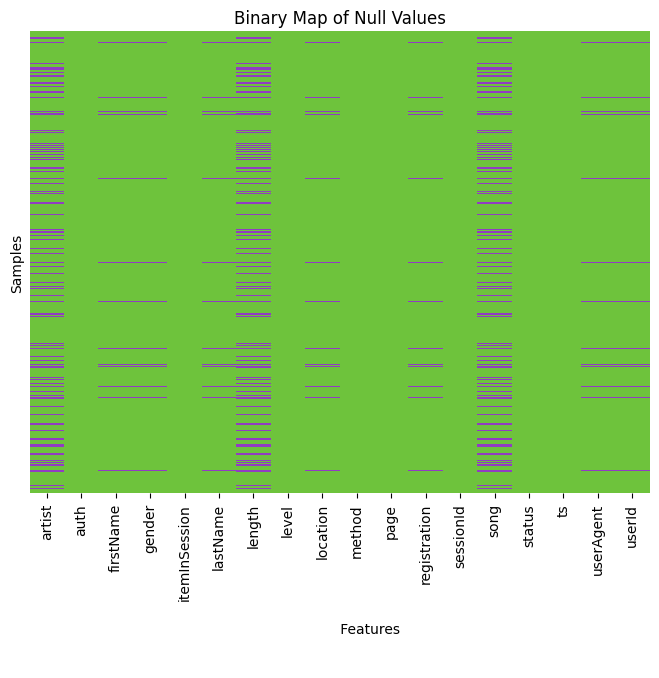

In [9]:
fig, ax = plt.subplots(figsize=(8, 6))

sns.heatmap(
    psdf.toPandas().isnull(),
    cbar=False,
    yticklabels=False,
    cmap=["#6EC33C", "#913CC3"],
    ax=ax,
)

ax.set_xlabel(
    """
              Features

              """
)
ax.set_ylabel("Samples")
ax.set_title("Binary Map of Null Values")

In [10]:
df = psdf.toPandas()
null_values = psdf.toPandas().isnull()

null_relations = {}


for column in df.columns:
    rows_with_nulls = df[df[column].isnull()]
    related_columns = rows_with_nulls.columns[rows_with_nulls.isnull().any()].tolist()

    null_relations[column] = related_columns

del df
null_relations

{'artist': ['artist',
  'firstName',
  'gender',
  'lastName',
  'length',
  'location',
  'registration',
  'song',
  'userAgent',
  'userId'],
 'auth': [],
 'firstName': ['artist',
  'firstName',
  'gender',
  'lastName',
  'length',
  'location',
  'registration',
  'song',
  'userAgent',
  'userId'],
 'gender': ['artist',
  'firstName',
  'gender',
  'lastName',
  'length',
  'location',
  'registration',
  'song',
  'userAgent',
  'userId'],
 'itemInSession': [],
 'lastName': ['artist',
  'firstName',
  'gender',
  'lastName',
  'length',
  'location',
  'registration',
  'song',
  'userAgent',
  'userId'],
 'length': ['artist',
  'firstName',
  'gender',
  'lastName',
  'length',
  'location',
  'registration',
  'song',
  'userAgent',
  'userId'],
 'level': [],
 'location': ['artist',
  'firstName',
  'gender',
  'lastName',
  'length',
  'location',
  'registration',
  'song',
  'userAgent',
  'userId'],
 'method': [],
 'page': [],
 'registration': ['artist',
  'firstName',
  '

# Exploring Features

## Flag Cancelled Users

In [97]:
cancelled_user_list = (
    psdf[["userId"]]
    .filter(col("page").isin(["Cancellation Confirmation"]))
    .distinct()
    .toPandas()
    .userId.tolist()
)


def flag_rows(df, column_name, check_list, flagged_column_name):
    def check_list_udf(value):
        return 1 if value in check_list else 0

    check_list_udf = udf(check_list_udf, IntegerType())

    df = df.withColumn(flagged_column_name, check_list_udf(df[column_name]))

    return df



psdf = flag_rows(psdf,"userId",cancelled_user_list,"cancel_flag")


psdf.filter(col('cancel_flag') == 1).groupBy('userId').count().count()

52

## Pages

In [36]:
psdf.groupBy("page").count().orderBy(col("count").desc()).toPandas()

,page,count
0,NextSong,228108
1,Home,14457
2,Thumbs Up,12551
3,Add to Playlist,6526
4,Add Friend,4277
5,Roll Advert,3933
6,Login,3241
7,Logout,3226
8,Thumbs Down,2546
9,Downgrade,2055


In [11]:
null_user = psdf.filter(col("userId").isNull())
null_user.groupBy("page").count().orderBy(col("count").desc()).toPandas()

,page,count
0,Home,4375
1,Login,3241
2,About,429
3,Help,272
4,Register,18
5,Error,6
6,Submit Registration,5


In [12]:
temp_df = (
    psdf.na.drop(subset=["userAgent"])
    .groupBy("page")
    .count()
    .orderBy(col("count").desc())
    .toPandas()
)

temp_df.page.to_list()

['NextSong',
 'Thumbs Up',
 'Home',
 'Add to Playlist',
 'Add Friend',
 'Roll Advert',
 'Logout',
 'Thumbs Down',
 'Downgrade',
 'Settings',
 'Help',
 'Upgrade',
 'About',
 'Save Settings',
 'Error',
 'Submit Upgrade',
 'Submit Downgrade',
 'Cancel',
 'Cancellation Confirmation']

<Axes: xlabel='page'>

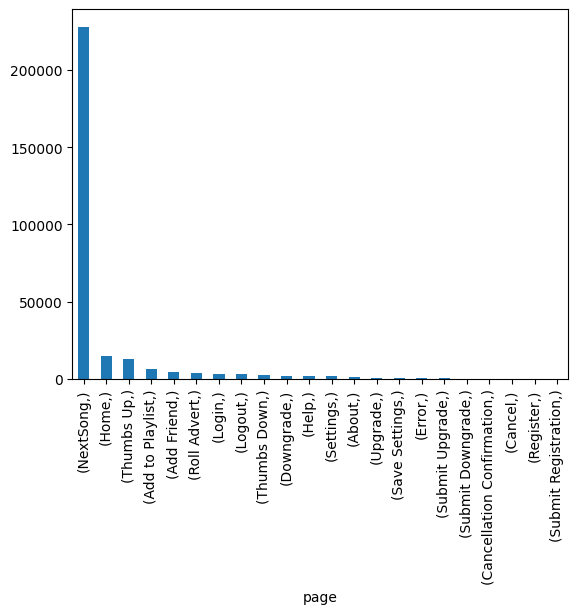

In [13]:
page_df = psdf[["page"]].toPandas()
page_df.value_counts().plot(kind="bar")

### Unique Counts of Upgrades/Downgrades


In [67]:
service_change = [
    "Downgrade",
    "Upgrade",
    "Submit Upgrade",
    "Submit Downgrade",
    "Cancel",
    "Cancellation Confirmation",
]


service_change_df = style_df(
    psdf[["page","cancel_flag"]]
    .filter(col("page").isin(service_change))
    .groupBy("page")
    .count()
    .sort("count", ascending=False)
    .toPandas()
)

service_change_df.export_png("service_change.png")
service_change_df

,page,count
0,Downgrade,2055
1,Upgrade,499
2,Submit Upgrade,159
3,Submit Downgrade,63
4,Cancel,52
5,Cancellation Confirmation,52


In [68]:
service_change = [
    "Downgrade",
    "Submit Downgrade",
    "Cancel",
    "Cancellation Confirmation",
]


service_change_df = (
    psdf[["page", "userId",'cancel_flag']].filter(col("page").isin(service_change)).toPandas()
)

service_change_df = service_change_df.groupby("userId").value_counts().reset_index()

service_change_df = service_change_df.pivot(
    index="userId", columns="page", values="count"
).fillna(value=0)


# service_change_df[service_change_df['Cancellation Confirmation'] > 0].sum()

print(service_change_df)

page    Cancel  Cancellation Confirmation  Downgrade  Submit Downgrade
userId                                                                
2          0.0                        0.0       13.0               0.0
3          1.0                        1.0        2.0               0.0
4          0.0                        0.0       21.0               0.0
6          0.0                        0.0       41.0               0.0
9          0.0                        0.0       32.0               1.0
...        ...                        ...        ...               ...
300020     0.0                        0.0        1.0               0.0
300021     0.0                        0.0       17.0               1.0
300022     0.0                        0.0        1.0               0.0
300023     0.0                        0.0       12.0               1.0
300025     0.0                        0.0        7.0               0.0

[171 rows x 4 columns]


In [64]:
service_change_df[service_change_df["Submit Downgrade"] == 1].sort_values(
    "Downgrade", ascending=False
)

page,Cancel,Cancellation Confirmation,Downgrade,Submit Downgrade
userId,,,,
92,0.0,0.0,68.0,1.0
54,1.0,1.0,39.0,1.0
9,0.0,0.0,32.0,1.0
300011,0.0,0.0,32.0,1.0
74,0.0,0.0,31.0,1.0
100,0.0,0.0,30.0,1.0
81,0.0,0.0,26.0,1.0
300015,0.0,0.0,22.0,1.0
96,0.0,0.0,20.0,1.0


In [69]:
service_change_df

page,Cancel,Cancellation Confirmation,Downgrade,Submit Downgrade
userId,,,,
2,0.0,0.0,13.0,0.0
3,1.0,1.0,2.0,0.0
4,0.0,0.0,21.0,0.0
6,0.0,0.0,41.0,0.0
9,0.0,0.0,32.0,1.0
...,...,...,...,...
300020,0.0,0.0,1.0,0.0
300021,0.0,0.0,17.0,1.0
300022,0.0,0.0,1.0,0.0


In [76]:
service_change = [
    "Downgrade",
    "Submit Downgrade",
    "Cancel",
    "Cancellation Confirmation",
]


service_change_df = (
    psdf[["page", "userId", 'cancel_flag']]
    .filter((col("page").isin(service_change)) & (col('cancel_flag') == 1))
    .toPandas()
)


# service_change_df = service_change_df.groupby("userId").value_counts().reset_index()

# service_change_df = service_change_df.pivot(
#     index="userId", columns="page", values="count"
# ).fillna(value=0)

# service_funnel = service_change_df[[service_change_df['cancel_flag'] ==0]].sum().sort_values(ascending=False)
# data = dict(stages=service_funnel.keys(), numbers=service_funnel.values)
# fig = px.funnel(data, x="numbers", y="stages")
# fig.show()

service_change_df



,page,userId,cancel_flag
0,Cancellation Confirmation,18,1
1,Cancellation Confirmation,32,1
2,Cancellation Confirmation,125,1
3,Cancellation Confirmation,105,1
4,Cancellation Confirmation,17,1
5,Cancellation Confirmation,143,1
6,Cancellation Confirmation,101,1
7,Cancellation Confirmation,129,1
8,Cancellation Confirmation,121,1
9,Cancellation Confirmation,51,1


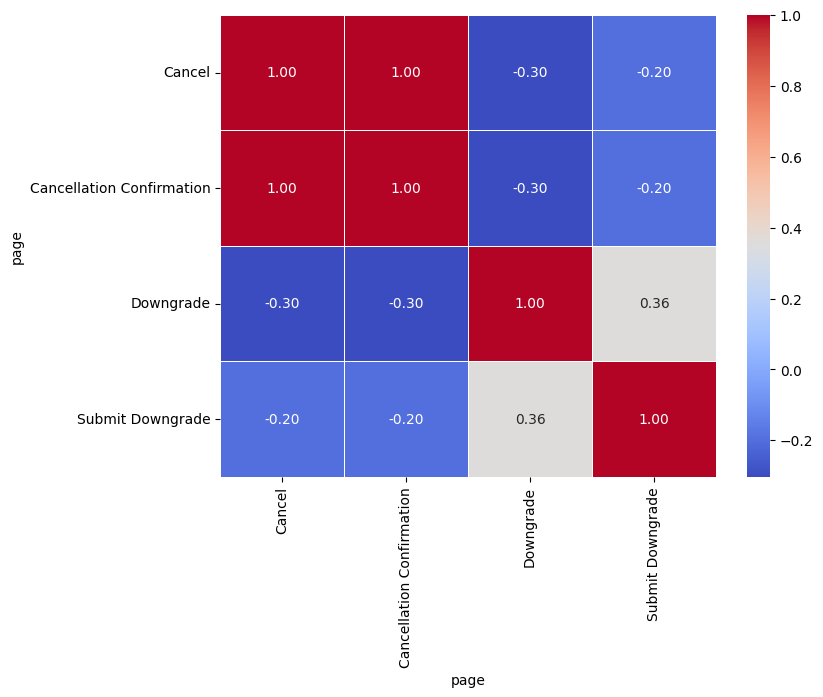

In [18]:

# Heatmap to show correlation between features
plt.figure(figsize=(8, 6))
sns.heatmap(service_change_df.corr(), annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5)
plt.show()



In [19]:
temp_df = psdf[["artist"]].toPandas().dropna().value_counts().reset_index()


temp_df = temp_df.rename(columns={'count':'song_plays'})


temp_df =temp_df['song_plays'].value_counts().reset_index()
temp_df =temp_df[temp_df['count'] > 10 ]

temp_df


,song_plays,count
0,1,5809
1,2,2616
2,3,1651
3,4,1075
4,5,757
...,...,...
67,83,11
68,103,11
69,73,11
70,75,11


# Feature Extraction

## Song Plays Per

In [20]:
psdf.createOrReplaceTempView("user_log_table")
spark.udf.register(
    "get_hour", lambda x: int(datetime.datetime.fromtimestamp(x / 1000.0).hour)
)
songs_in_hour = spark.sql(
    """
          SELECT get_hour(ts) AS hour, COUNT(*) as plays_per_hour
          FROM user_log_table
          WHERE page = "NextSong"
          GROUP BY hour
          ORDER BY cast(hour as int) ASC
          """
)

songs_in_hour_df = songs_in_hour.toPandas()

<Axes: >

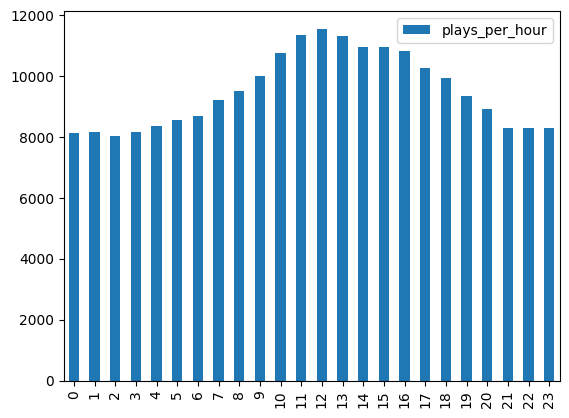

In [21]:
songs_in_hour_df.plot(kind="bar")

In [22]:
songs_listened = psdf.filter(col("artist").isNotNull()).groupBy(col("userId")).count()

songs_listened.show()

+------+-----+
|userId|count|
+------+-----+
|   148|  398|
|   137|  154|
|    85| 3616|
|    65| 2113|
|    53| 1746|
|   133|   32|
|    78|  254|
|    34|   53|
|   101| 1797|
|   126| 2577|
|   115| 1737|
|    81| 1974|
|    28| 1457|
|    76|  212|
|    27|  220|
|    26|  255|
|    44|  429|
|   103| 1073|
|    12|  867|
|    91| 2580|
+------+-----+
only showing top 20 rows



In [24]:
psdf[["userId", "user_cancel"]].filter(col("user_cancel") == 1).createOrReplaceTempView(
    "cancelled_users_lookup"
)
query = spark.sql(
    """
    SELECT DISTINCT
       ul.userId,
       ul.level,
       ul.user_cancel
    FROM user_log as ul 
    JOIN
       cancelled_users_lookup as cul
    ON
       cul.userId = ul.userId
    ORDER BY
       ul.userId ASC
"""
)

query.show()

+------+-----+-----------+
|userId|level|user_cancel|
+------+-----+-----------+
|     3| paid|          1|
|    12| free|          1|
|    12| paid|          1|
|    17| paid|          1|
|    17| free|          1|
|    18| paid|          1|
|    28| free|          1|
|    28| paid|          1|
|    29| free|          1|
|    29| paid|          1|
|    32| free|          1|
|    32| paid|          1|
|    51| paid|          1|
|    53| free|          1|
|    53| paid|          1|
|    54| paid|          1|
|    54| free|          1|
|    58| free|          1|
|    58| paid|          1|
|    70| paid|          1|
+------+-----+-----------+
only showing top 20 rows



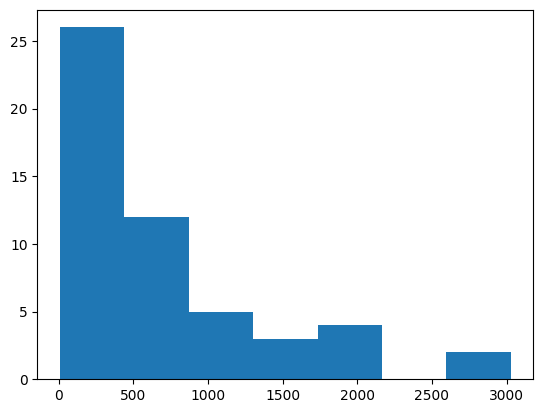

In [25]:
songs_listened_cancel = spark.sql(
    """
    WITH song_count AS (
        SELECT userId
        , COUNT(*) AS song_count
        FROM user_log_table
        WHERE artist IS NOT NULL
        GROUP BY userID
    )
    SELECT DISTINCT
        u.userId,
        s.song_count
        
    FROM 
        user_log_table AS u
    JOIN 
        song_count AS s ON u.userId = s.userId
    WHERE 
        u.page = "Cancellation Confirmation"
    ORDER BY s.song_count ASC
"""
)

slc = songs_listened_cancel.toPandas()
plt.hist(slc.song_count, bins=int(np.sqrt(len(slc.song_count))))
plt.show()

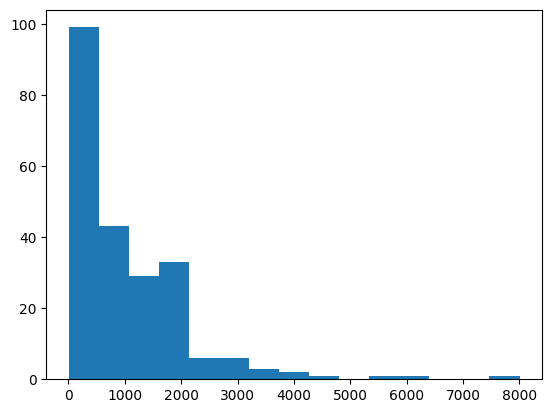

In [26]:
psdf.createOrReplaceTempView("user_log_table")
songs_listened = spark.sql(
    """
    WITH song_count AS (
        SELECT userId, COUNT(*) AS song_count
        FROM user_log
        WHERE artist IS NOT NULL
        GROUP BY userID
    )
    SELECT DISTINCT
        u.userId,
        s.song_count
        
    FROM 
        user_log AS u
    JOIN 
        song_count AS s ON u.userId = s.userId
    WHERE 
        u.page != "Cancellation Confirmation"
    ORDER BY s.song_count ASC
"""
)

sl = songs_listened.toPandas()
plt.hist(sl.song_count, bins=int(np.sqrt(len(sl.song_count))))

plt.show()

In [27]:
tsl = spark.sql(
    """
    SELECT userId, count(*) as song_count
    FROM user_log
    WHERE artist IS NOT NULL
    GROUP BY userId
    ORDER BY song_count DESC
"""
).toPandas()
tsl  # .song_count.plot(kind='hist' ,bins = 1 + int(np.log2(len(tsl.song_count))))

,userId,song_count
0,39,8002
1,92,5945
2,140,5664
3,300011,4619
4,124,4079
...,...,...
220,100024,22
221,100011,11
222,125,8
223,135,6


## Total Time Spent


In [28]:
tts = spark.sql(
    """
                 SELECT userId
                 ,sessionId
                 FROM user_log
                 WHERE userId IS NOT NULL
                 """
).toPandas()


tts.groupby("userId").value_counts().reset_index()

,userId,sessionId,count
0,2,1,428
1,2,1639,188
2,2,1928,102
3,2,1487,97
4,2,637,55
...,...,...,...
3171,300025,285,15
3172,300025,234,13
3173,300025,34,8
3174,300025,122,8


In [29]:
psdf[["userId", "page"]].filter((col("userId") == 39)).toPandas().value_counts()

userId  page            
39      NextSong            8002
        Thumbs Up            388
        Home                 355
        Add to Playlist      240
        Roll Advert          128
        Logout               124
        Add Friend           122
        Downgrade             73
        Thumbs Down           69
        Help                  46
        Settings              35
        About                 16
        Upgrade               14
        Error                  7
        Save Settings          6
        Submit Upgrade         4
        Submit Downgrade       3
Name: count, dtype: int64

## Page Interactions


In [30]:
page_interactions = ["Thumbs Up", "Add to Playlist", "Thumbs Down", "Add Friend"]

psdf[["userId"]].filter(
    col("page").isin(page_interactions) & ~col("userID").isNull()
).toPandas().value_counts().reset_index()

,userId,count
0,39,819
1,300011,717
2,92,655
3,140,643
4,300021,568
...,...,...
216,100024,5
217,100017,4
218,100011,3
219,200007,3


In [31]:
page_issues = ["Help", "Error"]

psdf[["userId"]].filter(
    col("page").isin(page_issues) & ~col("userID").isNull()
).toPandas().value_counts().reset_index()

,userId,count
0,39,53
1,92,43
2,140,41
3,300017,32
4,300011,32
...,...,...
192,47,1
193,100019,1
194,123,1
195,57,1


## User Account Level


User account level 

<Axes: xlabel='level'>

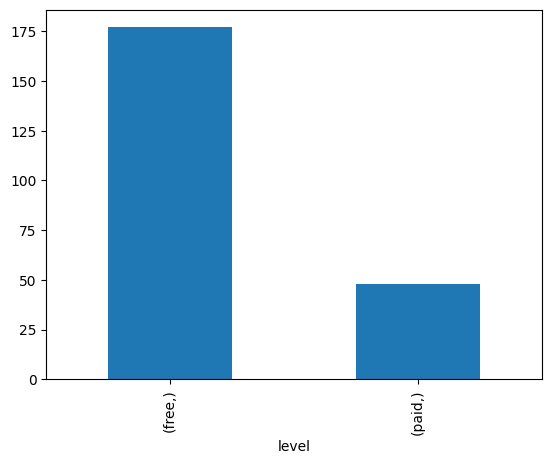

In [32]:
ual = psdf[["userId", "level", "ts"]].toPandas()

ual = ual.sort_values("ts").drop_duplicates(subset="userId", keep="first")


ual = ual[["userId", "level"]].dropna(subset="userId")


ual[["level"]].value_counts().plot(kind="bar")

<Axes: xlabel='level'>

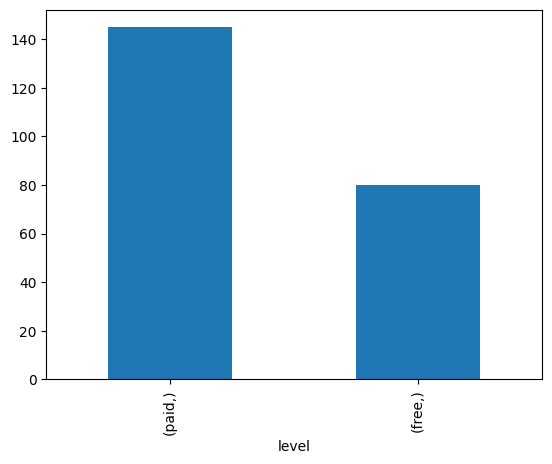

In [33]:
ual = psdf[["userId", "level", "ts"]].toPandas()

ual = ual.sort_values("ts", ascending=False).drop_duplicates(
    subset="userId", keep="first"
)


ual = ual[["userId", "level"]].dropna(subset="userId")


ual[["level"]].value_counts().plot(kind="bar")

<Axes: xlabel='status'>

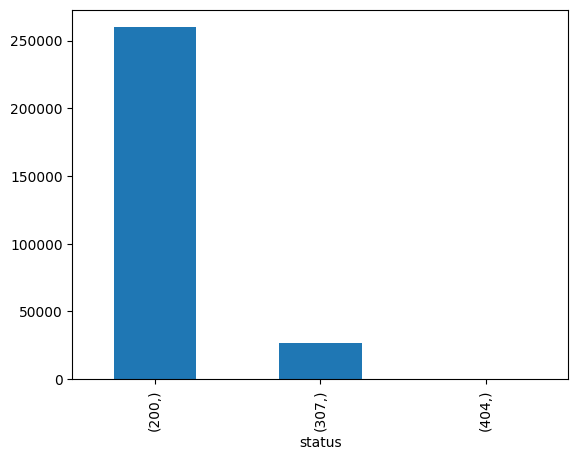

In [34]:
status = spark.sql(
    """
    SELECT 
        status
    FROM user_log
          """
).toPandas()

status.value_counts().plot(kind="bar")

## Time Spent

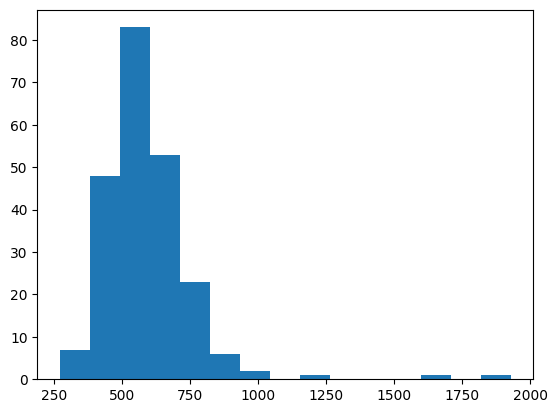

In [35]:
tsl = psdf[["length", "sessionId", "userId"]].toPandas()

avg_session = (
    tsl.groupby(["userId", "sessionId"])
    .max()
    .reset_index()[["userId", "length"]]
    .groupby("userId")
    .mean()
    .round()
)
plt.hist(x=avg_session.length, bins=int(np.sqrt(len(avg_session.length))))
plt.show()